In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
# !pip install gtts pydub audioop-lts
from pydub import AudioSegment
import time
import os
import copy
import pandas as pd
from gtts import gTTS
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, AudioFileClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings
    )
from utils_video import (
    create_component_words_text, add_text_and_save_clip, determine_if_text_size_too_big, create_full_video_file
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, load_audio, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations, compute_start_times_for_clips
)
from video_file_configs.v003_one_character_vocab_person import (
    CHANNEL_TITLE, VIDEO_NUMBER, VIDEO_NAME, VIDEO_STRUCTURE,
    INTR_COUNT_STR, INTRO_DURATION_STR, FEEDBACK,
    nonvocab_audio_path, nonvocab_slides,
    dict_recordings,
    BG_SIZE, MAX_LINE_LENGTH_CONSTANT,
    TEXT_COLOR, BG_COLOR, TEXT_SPACING, TEXT_SPACING_COMPONENTS, MAX_LINE_LENGTH_CONSTANT, FONT_SIZES_BY_TYPE, hanzi_font_path,
    NONVOCAB_AUDIO_TEXT_FONT, NONVOCAB_AUDIO_TEXT_FILL,
    NONVOCAB_AUDIO_TEXT_SPACING, NONVOCAB_AUDIO_TEXT_ALIGN, NONVOCAB_AUDIO_TEXT_Y,
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

# 0. Create dataframe of settings

In [3]:
# Create settings df
df_all_recordings_tomake = fill_default_settings(dict_recordings)

# Create folder for non-audio recordings for this project
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Create folder if not exists
    if not os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}"):
        os.mkdir(f"{nonvocab_audio_path}/{rrow['recording_name']}")

df_all_recordings_tomake

,recording_id,filename_suffix,min_adu,min_per,contains_character,types_allowed,exclude_words,min_priority,max_priority,min_known_english_prompt,max_known_english_prompt,min_known_pinyin_prompt,max_known_pinyin_prompt,sort_keys,sort_asc,min_combo_quality,category_type,cat1_values_allowed,types_allowed_str,min_date,recording_id_code,categories_allowed,recording_name
0,016,_one_character_vocab_person,3,3,人,"[combo, no combo, two word, prefix, single cha...","[维吾尔族人, 很仔细的人, 好心人, 看个人, 恐高的人, 圣诞老人, 传统的人, 幽默的人]",1,4,1,6,1,6,"[category1, category2, pinyin]","[True, True, True]",6,,None,,2025-01-01,efirst_word_only,None,0916_016_efirst_word_only_p1_4_one_character_v...


# 1. Load data

In [4]:
truly_load_data = False
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 0
(5274, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,4,组合,zǔ hé,combination,combo,1.0,5.0,5.0,5.0,NaN,general,NaN,2.0,组,set,合适,suitable,NaN,NaN,NaN,NaN,这个组合在比赛中获得了第一名。,Zhège zǔhé zài bǐsài zhōng huòdé le dì yī míng.,This group won first place in the competition.,2025-01-02,NaN,5.0,5.0
1,137,好转,hǎo zhuǎn,improve,combo,1.0,5.0,2.0,5.0,NaN,general,NaN,2.0,好,good,转,turn,NaN,NaN,NaN,NaN,病人的情况已经好转了。,Bìngrén de qíngkuàng yǐjīng hǎozhuǎn le.,The patient's condition has improved.,2025-01-02,NaN,5.0,5.0
2,154,意见,yì jiàn,opinion,combo,1.0,4.0,2.0,5.0,NaN,people,NaN,2.0,意思,meaning,见,to see,NaN,NaN,NaN,NaN,大家都提出了不同意见,Dàjiā dōu tíchū le bùtóng yìjiàn,Everyone gave different opinions,2025-01-02,NaN,5.0,5.0


# 2. Select data

In [5]:
dfs_vocab_lists = {}
n_vocab_by_recording = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_vocab_lists[rrow['recording_name']] = filter_df_to_vocab_of_interest(df_all_vocab, rrow)
    n_vocab_by_recording[rrow['recording_name']] = len(dfs_vocab_lists[rrow['recording_name']])
    print(rrow['recording_name'], n_vocab_by_recording[rrow['recording_name']])

dfs_vocab_lists[rrow['recording_name']].head(3)

0916_016_efirst_word_only_p1_4_one_character_vocab_person 44


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,155,创始人,chuàng shǐ rén,founder;creator,combo,2.0,3.0,2.0,5.0,NaN,career,NaN,2.0,创造,to create,开始,to start,人,person,NaN,NaN,他是公司的创始人,Tā shì gōngsī de chuàngshǐrén,He is the company’s founder,2025-01-02,NaN,5.0,5.0
1,1369,经纪人,jīng jì rén,agent;broker;middleman,combo,2.0,5.0,3.0,5.0,NaN,career,NaN,3.0,经纪,manager,人,person,NaN,NaN,NaN,NaN,明星的经纪人安排了采访,Míngxīng de jīngjìrén ānpái le cǎifǎng,The star’s agent arranged the interview,2025-01-02,NaN,5.0,5.0
2,1129,人事部,rén shì bù,human resources department;H.R.,combo,3.0,NaN,1.0,6.0,NaN,career,NaN,3.0,人,person,事,affair,部,department,NaN,NaN,请去人事部报到,qǐng qù rén shì bù bào dào,please report to the HR department,2025-01-02,NaN,5.0,5.0


# 3. Create vocabulary audio recordings

In [6]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if rrow['recording_id'] == '005':
        dfs_vocab_lists[rrow['recording_name']] = compute_pinyin_and_create_recordings(dfs_vocab_lists[rrow['recording_name']])
    for i_row, row in dfs_vocab_lists[rrow['recording_name']].iterrows():
        print(f'{rrow['recording_name']} row{i_row}')
        create_tts_files_for_one_vocab_word(row, rrow)

0916_016_efirst_word_only_p1_4_one_character_vocab_person row0
0.000s, ALREADY EXISTS, zh, 创始人
0.000s, ALREADY EXISTS, zh_slow, 创始人
0.000s, ALREADY EXISTS, english, founder;creator
0916_016_efirst_word_only_p1_4_one_character_vocab_person row1
0.000s, ALREADY EXISTS, zh, 经纪人
0.000s, ALREADY EXISTS, zh_slow, 经纪人
0.000s, ALREADY EXISTS, english, agent;broker;middleman
0916_016_efirst_word_only_p1_4_one_character_vocab_person row2
0.000s, ALREADY EXISTS, zh, 人事部
0.000s, ALREADY EXISTS, zh_slow, 人事部
0.000s, ALREADY EXISTS, english, human resources department;H.R.
0916_016_efirst_word_only_p1_4_one_character_vocab_person row3
0.000s, ALREADY EXISTS, zh, 个人主义
0.000s, ALREADY EXISTS, zh_slow, 个人主义
0.000s, ALREADY EXISTS, english, individualism
0916_016_efirst_word_only_p1_4_one_character_vocab_person row4
0.000s, ALREADY EXISTS, zh, 惊人
0.000s, ALREADY EXISTS, zh_slow, 惊人
0.000s, ALREADY EXISTS, english, astonishing;amazing
0916_016_efirst_word_only_p1_4_one_character_vocab_person row5
0.000s,

## 3b. Compute durations of combined audios for each vocab word

In [7]:
df_vocab_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio_duration_file_name = f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_vocab_only.csv"
    if os.path.exists(audio_duration_file_name):
        df_vocab_audio_durations[rrow['recording_name']] = pd.read_csv(audio_duration_file_name)
        print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_vocab_audio_durations[rrow['recording_name']].shape}")
    else:
        df_vocab_audio_durations[rrow['recording_name']] = combine_audio_files_and_compute_durations(dfs_vocab_lists[rrow['recording_name']], rrow)
        df_vocab_audio_durations[rrow['recording_name']].to_csv(audio_duration_file_name, index=False)

    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_file_path'] = None
    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_pause_ms'] = None
    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_key'] = None
df_vocab_audio_durations[rrow['recording_name']].head(3)

0.30 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 0, 创始人
0.28 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 1, 经纪人
0.28 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 2, 人事部
0.27 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 3, 个人主义
0.27 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 4, 惊人
0.28 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 5, 大陆人
0.29 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 6, 人民币
0.28 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 7, 个人资料
0.28 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 8, 机器人
0.28 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 9, 无人机
0.33 seconds, recid0916_016_efirst_word_only_p1_4_one_character_vocab_person, row 10, 感人
0.29 seconds, recid0

,chinese,pinyin,english,d_chinese,d_chinese_slow,d_english,rel_start_english,rel_start_chinese,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,创始人,chuàng shǐ rén,founder;creator,1.440,1.680,1.800,0,2.300,6.720,6.719667,None,None,None
1,经纪人,jīng jì rén,agent;broker;middleman,1.416,1.656,2.856,0,3.356,7.728,7.727667,None,None,None
2,人事部,rén shì bù,human resources department;H.R.,1.320,1.536,3.240,0,3.740,7.896,7.895667,None,None,None


# 4. Create non-vocab audio recordings

In [8]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Fill nonvocab audio recordings with data from vocab, if needed
    # Define audio variables
    audio_filler_variables = {
        'audio_duration_minutes': df_vocab_audio_durations[rrow['recording_name']]['combined'].sum() / 60,
        'n_vocab': len(df_vocab_audio_durations[rrow['recording_name']]),
    }

    # Fill text for audio recordings
    for nv_name, nv_settings in nonvocab_slides.items():
        if 'chinese' not in nv_settings.keys():
            nonvocab_slides[nv_name]['chinese'] = nv_settings['chinese_unfill'].format(**audio_filler_variables)
            nonvocab_slides[nv_name]['pinyin'] = nv_settings['pinyin_unfill'].format(**audio_filler_variables)
            nonvocab_slides[nv_name]['english'] = nv_settings['english_unfill'].format(**audio_filler_variables)

    # Generate non-vocab recording
    for nv_name, nv_settings in nonvocab_slides.items():
        # Generate audio if not already exists
        nv_settings['file_path'] = f"{nonvocab_audio_path}/{rrow['recording_name']}/{nv_settings['chinese']}.mp3"
        if not os.path.exists(nv_settings['file_path']):
            gTTS(nv_settings['chinese'], lang='zh').save(nv_settings['file_path'])
            print(f'Generated {nv_settings['chinese']}')
        else:
            print(f'{nv_name} audio already generated: {nv_settings['chinese']}')

        # Record audio duration
        audio_duration = AudioFileClip(nv_settings['file_path']).duration
        # nonvocab_slides[nv_name]['duration'] = audio_duration

        # Insert audio duration into `df_vocab_audio_durations`
        if nv_settings['change_index'] is None:
            nv_settings['change_index'] = len(df_vocab_audio_durations[rrow['recording_name']])

        df_vocab_audio_durations[rrow['recording_name']].loc[nv_settings['change_index']] = pd.Series({
            'chinese': nv_settings['chinese'],
            'pinyin': nv_settings['pinyin'],
            'english': nv_settings['english'],
            'combined': audio_duration + nv_settings['pause_ms']/1000,
            'nonvocab_file_path': nv_settings['file_path'],
            'nonvocab_pause_ms': nv_settings['pause_ms'],
            'nonvocab_key': nv_name,
            })

    # Re-fix index
    df_vocab_audio_durations[rrow['recording_name']].index = df_vocab_audio_durations[rrow['recording_name']].index + 1
    df_vocab_audio_durations[rrow['recording_name']] = df_vocab_audio_durations[rrow['recording_name']].sort_index().reset_index(drop=True)

    # Compute more timestamps
    df_vocab_audio_durations[rrow['recording_name']]['end'] = df_vocab_audio_durations[rrow['recording_name']]['combined'].cumsum()
    df_vocab_audio_durations[rrow['recording_name']]['start'] = df_vocab_audio_durations[rrow['recording_name']]['end'] - df_vocab_audio_durations[rrow['recording_name']]['combined']
    if rrow['recording_id'] in ['004', '008', '010', '014', '016']:
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
    elif rrow['recording_id'] == '013':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_component_words'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_component_words']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent_english']
    elif rrow['recording_id'] == '006':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_component_words'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_component_words']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
    elif rrow['recording_id'] == '001':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent_english']
    elif rrow['recording_id'] == '012':
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
    elif rrow['recording_id'] == '015':
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
    else:
        raise ValueError(f"Unsupported recording id {rrow['recording_id']}")
    
    # Save durations dataframe with static audio as a csv
    df_vocab_audio_durations[rrow['recording_name']].to_csv(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv", index=False)

    # Update nonvocab_slide settings info with duration and start
    for i_row, row in df_vocab_audio_durations[rrow['recording_name']].iterrows():
        if row['nonvocab_key'] is not None:
            nonvocab_slides[row['nonvocab_key']]['duration'] = row['combined']
            nonvocab_slides[row['nonvocab_key']]['start'] = row['start']

df_vocab_audio_durations[rrow['recording_name']].head(30)

intro audio already generated: 欢迎观看我的普通话数据库视频 3: 一个字，多个单词: 人
word_list audio already generated: 这些是将在接下来的5分钟内复习的44个单词
end audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,d_chinese,d_chinese_slow,d_english,rel_start_english,rel_start_chinese,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_chinese,start_english
0,欢迎观看我的普通话数据库视频 3: 一个字，多个单词: 人,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,9.020000,audio_files/files_by_video//0916_016_efirst_wo...,500,intro,9.020000,0.000000,NaN,NaN
1,这些是将在接下来的5分钟内复习的44个单词,Zhèxiē shì jiàng zài jiē xiàlái de 5 fēnzhōng ...,These are the 44 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,7.080000,audio_files/files_by_video//0916_016_efirst_wo...,500,word_list,16.100000,9.020000,NaN,NaN
2,创始人,chuàng shǐ rén,founder;creator,1.440,1.680,1.800,0.0,2.300,6.720,6.719667,None,None,None,22.819667,16.100000,18.400000,16.100000
3,经纪人,jīng jì rén,agent;broker;middleman,1.416,1.656,2.856,0.0,3.356,7.728,7.727667,None,None,None,30.547333,22.819667,26.175667,22.819667
4,人事部,rén shì bù,human resources department;H.R.,1.320,1.536,3.240,0.0,3.740,7.896,7.895667,None,None,None,38.443000,30.547333,34.287333,30.547333
5,个人主义,gè rén zhǔ yì,individualism,1.464,1.704,1.560,0.0,2.060,6.528,6.527667,None,None,None,44.970667,38.443000,40.503000,38.443000
6,惊人,jīng rén,astonishing;amazing,1.128,1.296,2.256,0.0,2.756,6.480,6.479667,None,None,None,51.450333,44.970667,47.726667,44.970667
7,大陆人,dà lù rén,mainlanders,1.344,1.560,1.368,0.0,1.868,6.072,6.071667,None,None,None,57.522000,51.450333,53.318333,51.450333
8,人民币,rén mín bì,Chinese yuan;RMB,1.248,1.464,2.688,0.0,3.188,7.200,7.199667,None,None,None,64.721667,57.522000,60.710000,57.522000
9,个人资料,gè rén zī liào,profile,1.560,1.800,1.056,0.0,1.556,6.216,6.215667,None,None,None,70.937333,64.721667,66.277667,64.721667


# 5. Combine individual vocab into final audio recording

In [ ]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    start_time = time.time()
    # Construct list of individual audio files
    all_audio_files = []
    for i_row, row in df_vocab_audio_durations[rrow['recording_name']].iterrows():
        if row['nonvocab_file_path'] is not None:
            all_audio_files.append(AudioSegment.from_mp3(row['nonvocab_file_path']))
            all_audio_files.append(AudioSegment.silent(duration=row['nonvocab_pause_ms']))
        else:
            # vocab
            all_audio_files.append(AudioSegment.from_mp3(f"audio_files/rows/{rrow['recording_id']}/{row['chinese']}.mp3"))

    # Construct and export whole audio file
    audio_concat = all_audio_files[0]
    for audio in all_audio_files[1:]:
        audio_concat += audio
    audio_concat.export(f"{nonvocab_audio_path}{rrow['recording_name']}/audio.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f}s, {nonvocab_audio_path}{rrow['recording_name']}/audio.mp3")

4.54s, audio_files/files_by_video/0916_016_efirst_word_only_p1_4_one_character_vocab_person.mp3


# 6. Create images for video

In [10]:
# Load audio data, already computed above
# If using premade audio to make a video, then just run this:
df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    try:
        df_audio_durations[rrow['recording_name']] = pd.read_csv(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_audio_durations[rrow['recording_name']].head()

0916_016_efirst_word_only_p1_4_one_character_vocab_person loaded


,chinese,pinyin,english,d_chinese,d_chinese_slow,d_english,rel_start_english,rel_start_chinese,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_chinese,start_english
0,欢迎观看我的普通话数据库视频 3: 一个字，多个单词: 人,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,9.020000,audio_files/files_by_video//0916_016_efirst_wo...,500.0,intro,9.020000,0.000000,NaN,NaN
1,这些是将在接下来的5分钟内复习的44个单词,Zhèxiē shì jiàng zài jiē xiàlái de 5 fēnzhōng ...,These are the 44 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,7.080000,audio_files/files_by_video//0916_016_efirst_wo...,500.0,word_list,16.100000,9.020000,NaN,NaN
2,创始人,chuàng shǐ rén,founder;creator,1.440,1.680,1.800,0.0,2.300,6.720,6.719667,NaN,NaN,NaN,22.819667,16.100000,18.400000,16.100000
3,经纪人,jīng jì rén,agent;broker;middleman,1.416,1.656,2.856,0.0,3.356,7.728,7.727667,NaN,NaN,NaN,30.547333,22.819667,26.175667,22.819667
4,人事部,rén shì bù,human resources department;H.R.,1.320,1.536,3.240,0.0,3.740,7.896,7.895667,NaN,NaN,NaN,38.443000,30.547333,34.287333,30.547333


## 6a. Vocab words

0916_016_efirst_word_only_p1_4_one_character_vocab_person; 0: 创始人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 1: 经纪人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 2: 人事部
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 3: 个人主义
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 4: 惊人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 5: 大陆人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 6: 人民币
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 7: 个人资料
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 8: 机器人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 9: 无人机
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 10: 感人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 11: 迷人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 12: 吓人的
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 13: 个人
0916_016_efirst_word_only_p1_4_one_character_vocab_person; 14: 个人选择
0916_0


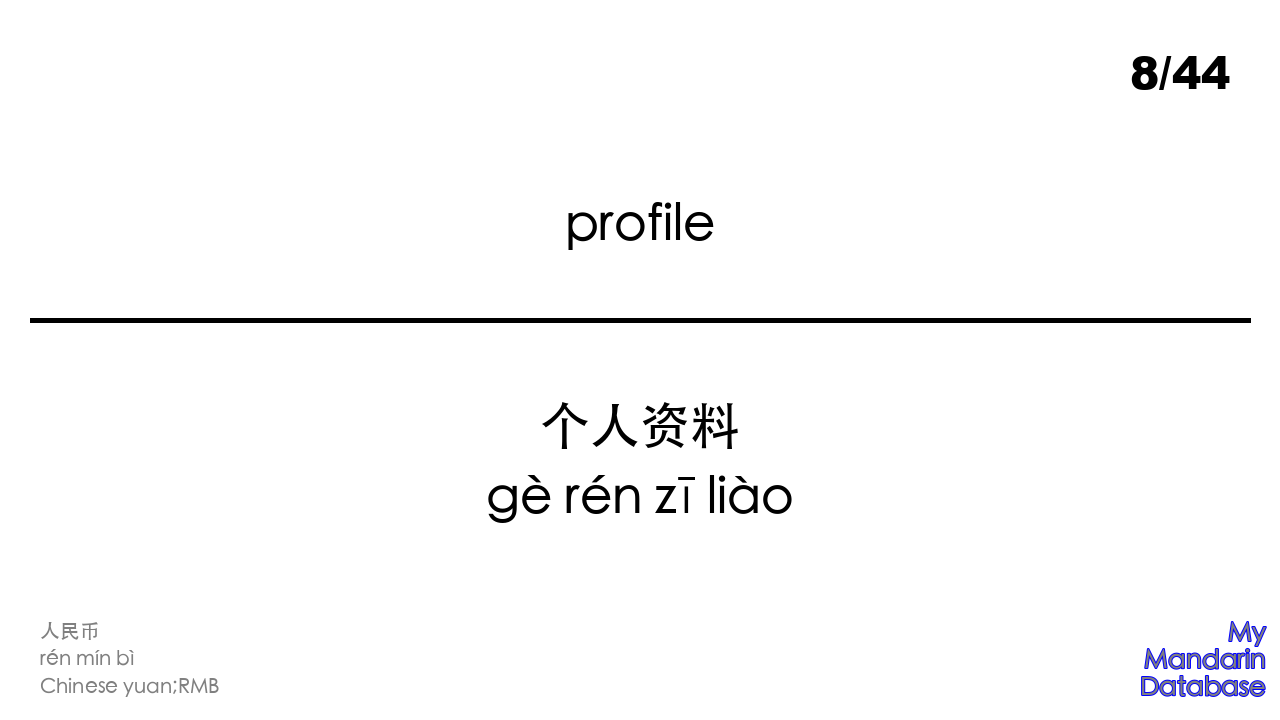

In [11]:
# Create all clips
clips = {}

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    previous_word = ''
    previous_sent = ''

    if not os.path.exists(f"audio_files/img_for_video/{rrow['recording_id']}"):
        os.mkdir(f"audio_files/img_for_video/{rrow['recording_id']}")
    clips[rrow['recording_name']] = []
    df_all_words = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)
    for idx, row in df_all_words.iterrows():
        if rrow['recording_id'] == '013':
            # Establish texts
            if not pd.isna(row['word4']):
                font_size_components = FONT_SIZES_BY_TYPE['components'] * .5
            elif not pd.isna(row['word3']):
                font_size_components = FONT_SIZES_BY_TYPE['components'] * .75
            else:
                font_size_components = FONT_SIZES_BY_TYPE['components']
            texts = {
                'chinese': {
                    'text': f"{row['chinese']} ({row['pinyin']})",
                    'y_pos': 50,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_component_words'] - row['start_chinese'],
                    'timestamp_start': row['start_chinese'],
                    'img_file_suffix': '_chinese',
                    },
                'component_words': {
                    'text': create_component_words_text(row),
                    'y_pos': 220,
                    'font_path': hanzi_font_path,
                    'font_size': font_size_components,
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING_COMPONENTS,
                    'align': 'center',
                    'duration': row['start_english'] - row['start_component_words'],
                    'timestamp_start': row['start_component_words'],
                    'img_file_suffix': '_component_words',
                    },
                'english': {
                    'text': row['english'],
                    'y_pos': 250,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_sent'] - row['start_english'],
                    'timestamp_start': row['start_english'],
                    'img_file_suffix': '_component_words_english',
                    },
                'sentence_chinese': {
                    'text': row['sentence'],
                    'y_pos': 370,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent_chinese'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': None,
                    'timestamp_start': None,
                    'img_file_suffix': None,
                    },
                'sentence_pinyin': {
                    'text': row['sentence_pinyin'],
                    'y_pos': 440,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_sent_english'] - row['start_sent'],
                    'timestamp_start': row['start_sent'],
                    'img_file_suffix': '_sentence',
                    },
                'sentence_english': {
                    'text': row['sentence_english'],
                    'y_pos': 510,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['end'] - row['start_sent_english'],
                    'timestamp_start': row['start_sent_english'],
                    'img_file_suffix': '_sentence_e',
                    },
            }

            # Initialize image
            img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
            draw = ImageDraw.Draw(img)

            # Constant texts
            draw.text(text=f"{idx+1}/{n_vocab_by_recording[rrow['recording_name']]}", xy=(BG_SIZE[0] - 150, 40)
                        , font=ImageFont.truetype('Arial Black', 44), fill = 'black', align='center')
            draw.multiline_text(
                xy=(40, BG_SIZE[1] - 100)
                , text=previous_word
                , font=ImageFont.truetype(hanzi_font_path, 20)
                , fill='gray', spacing=10, align='left'
                )
            sent_font = ImageFont.truetype(hanzi_font_path, 20)
            longest_length = max([sent_font.getlength(x) for x in previous_sent.split('\n')])
            draw.multiline_text(
                xy=(BG_SIZE[0]/2 - longest_length/2, BG_SIZE[1] - 100)
                , text=previous_sent
                , font=sent_font
                , fill='gray', spacing=10, align='center'
                )
            draw.multiline_text(
                xy=(BG_SIZE[0] - 140, BG_SIZE[1] - 100)
                , text='My\nMandarin\nDatabase'
                , font=ImageFont.truetype(hanzi_font_path, 26)
                , fill='gray', spacing=2, align='right'
                , stroke_width=1, stroke_fill='blue'
                )
            previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
            previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

            # Add each text and create a new clip as appropriate
            current_image_file_path = f"audio_files/img_for_video/{rrow['recording_id']}/{row['chinese']}_"
            img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['component_words'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            draw.line([(30, 330), (BG_SIZE[0] - 30, 330)], fill='black', width=5, joint=None)
            img, draw, clips = add_text_and_save_clip(texts['sentence_chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path, save_clip=False)
            img, draw, clips = add_text_and_save_clip(texts['sentence_pinyin'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['sentence_english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
        
        elif rrow['recording_id'] == '016':
            texts = {
                'english': {
                    'text': row['english'],
                    'y_pos': 200,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_chinese'] - row['start'],
                    'timestamp_start': row['start'],
                    'img_file_suffix': '_english',
                    },
                'chinese': {
                    'text': f"{row['chinese']}\n{row['pinyin']}",
                    'y_pos': 400,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['end'] - row['start_chinese'],
                    'timestamp_start': row['start_chinese'],
                    'img_file_suffix': '_chinese',
                    },
            }

            # Initialize image
            img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
            draw = ImageDraw.Draw(img)

            # Constant texts
            draw.text(text=f"{idx+1}/{n_vocab_by_recording[rrow['recording_name']]}", xy=(BG_SIZE[0] - 150, 40)
                        , font=ImageFont.truetype('Arial Black', 44), fill = 'black', align='center')
            draw.multiline_text(
                xy=(40, BG_SIZE[1] - 100)
                , text=previous_word
                , font=ImageFont.truetype(hanzi_font_path, 20)
                , fill='gray', spacing=10, align='left'
                )
            draw.multiline_text(
                xy=(BG_SIZE[0] - 140, BG_SIZE[1] - 100)
                , text='My\nMandarin\nDatabase'
                , font=ImageFont.truetype(hanzi_font_path, 26)
                , fill='gray', spacing=2, align='right'
                , stroke_width=1, stroke_fill='blue'
                )
            previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"

            # Add each text and create a new clip as appropriate
            current_image_file_path = f"audio_files/img_for_video/{rrow['recording_id']}/{row['chinese']}_"
            img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            draw.line([(30, 320), (BG_SIZE[0] - 30, 320)], fill='black', width=5, joint=None)
            img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)

        
        # elif rrow['recording_id'] == '006':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     component_words_text = create_component_words_text(row)
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
        
        # elif rrow['recording_id'] == '001':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
        
        # elif rrow['recording_id'] == '012':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['start_sent'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        
        # elif rrow['recording_id'] in ['004', '008', '010', '014']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        
        # elif rrow['recording_id'] in ['015']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}\n --------- \n{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start'], row['start'], f"{rrow['recording_id']}/{row['chinese']}"))
        
        else:
            raise ValueError(f"Unknown vlaue of recording_id: {rrow['recording_id']}")
        
        print(f'{rrow['recording_name']}; {idx}: {row["chinese"]}')

clips[rrow['recording_name']][15].display_in_notebook()

## 6b. Intro slide


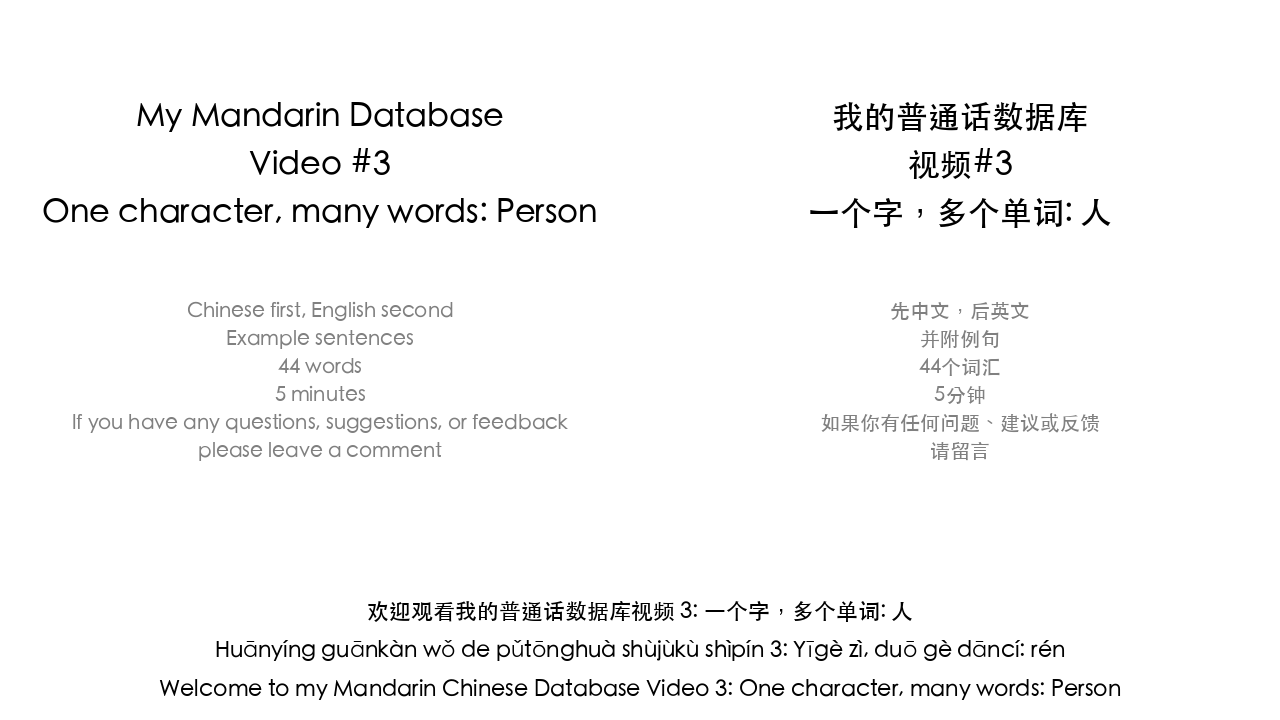

In [12]:
audio_duration_minutes = df_audio_durations[rrow['recording_name']]['end'].max() / 60 

intro_texts_dict = [
    {'text': f'{CHANNEL_TITLE[0]}\n{VIDEO_NUMBER[0]}\n{VIDEO_NAME[0]}',
     'text_chinese': f'{CHANNEL_TITLE[1]}\n{VIDEO_NUMBER[1]}\n{VIDEO_NAME[1]}',
     'font': ImageFont.truetype(hanzi_font_path, 32),
     'fill': 'black',
     'spacing': 20,
     'align': 'center',
     'y': 100,
     },
    {'text': f'{VIDEO_STRUCTURE[0]}\n{INTR_COUNT_STR[0].format(n_vocab_words=n_vocab_by_recording[rrow['recording_name']])}\n{INTRO_DURATION_STR[0].format(audio_duration_minutes=audio_duration_minutes)}\n{FEEDBACK[0]}',
     'text_chinese': f'{VIDEO_STRUCTURE[1]}\n{INTR_COUNT_STR[1].format(n_vocab_words=n_vocab_by_recording[rrow['recording_name']])}\n{INTRO_DURATION_STR[1].format(audio_duration_minutes=audio_duration_minutes)}\n{FEEDBACK[1]}',
     'font': ImageFont.truetype(hanzi_font_path, 20),
     'fill': 'gray',
     'spacing': 10,
     'align': 'center',
     'y': 300,
     },
]

# Initialize image
img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
draw = ImageDraw.Draw(img)

# Write title in english and chinese
for i_ts, text_settings in enumerate(intro_texts_dict):
    intro_texts_dict[i_ts]['length'] = max([text_settings['font'].getlength(x) for x in text_settings['text'].split('\n')])
    intro_texts_dict[i_ts]['length_chinese'] = max([text_settings['font'].getlength(x) for x in text_settings['text_chinese'].split('\n')])

    draw.text(
        xy=(BG_SIZE[0]/4 - intro_texts_dict[i_ts]['length']/2, intro_texts_dict[i_ts]['y']),
        text=intro_texts_dict[i_ts]['text'],
        font=intro_texts_dict[i_ts]['font'],
        fill=intro_texts_dict[i_ts]['fill'],
        spacing=intro_texts_dict[i_ts]['spacing'],
        align=intro_texts_dict[i_ts]['align'],
        )
    
    draw.text(
        xy=(BG_SIZE[0]*3/4 - intro_texts_dict[i_ts]['length_chinese']/2, intro_texts_dict[i_ts]['y']),
        text=intro_texts_dict[i_ts]['text_chinese'],
        font=intro_texts_dict[i_ts]['font'],
        fill=intro_texts_dict[i_ts]['fill'],
        spacing=intro_texts_dict[i_ts]['spacing'],
        align=intro_texts_dict[i_ts]['align'],
        )
    
# Write audio subtitles
intro_audio_text = f'{nonvocab_slides['intro']['chinese']}\n{nonvocab_slides['intro']['pinyin']}\n{nonvocab_slides['intro']['english']}'
intro_audio_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in intro_audio_text.split('\n')])
draw.text(
    xy=(BG_SIZE[0]/2 - intro_audio_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
    text=intro_audio_text,
    font=NONVOCAB_AUDIO_TEXT_FONT,
    fill=NONVOCAB_AUDIO_TEXT_FILL,
    spacing=NONVOCAB_AUDIO_TEXT_SPACING,
    align=NONVOCAB_AUDIO_TEXT_ALIGN,
    )

img_file_path = f"{nonvocab_audio_path}{rrow['recording_name']}/intro.png"
img.save(img_file_path)
my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6c. Final slide

"human resources department;H.R." reduced font size to 18
"human resources department;H.R." reduced font size to 16
"fascinating;enchanting;charming" reduced font size to 18
"fascinating;enchanting;charming" reduced font size to 16
"working-class person;wage slave" reduced font size to 18
"working-class person;wage slave" reduced font size to 16
"无家可归的人" reduced font size to 18
"无家可归的人" reduced font size to 16
"无家可归的人" reduced font size to 14



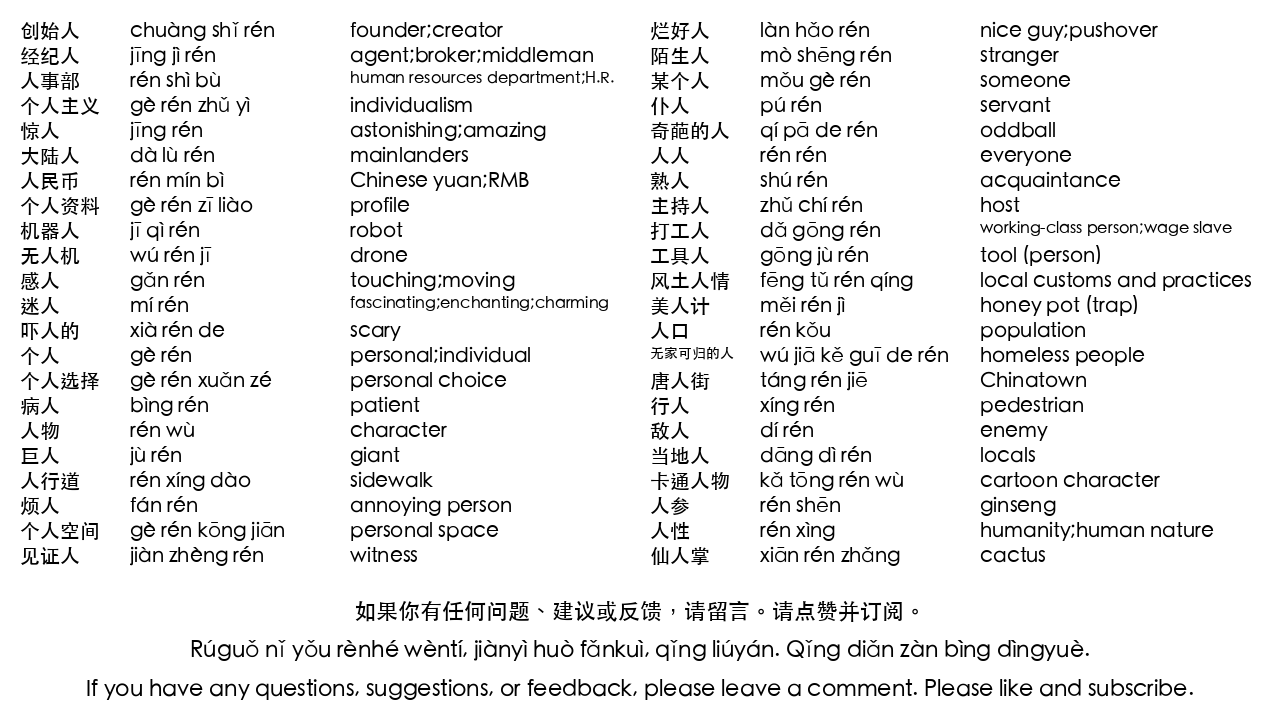

In [13]:
# Create slide with all words
# Audio: "here are the X words over the next X minutes"
ALL_WORDS_SLIDE_YTOP = 20
ALL_WORDS_SLIDE_YBOTTOM = 130
ALL_WORDS_SLIDE_XTOP = 20
ALL_WORDS_SLIDE_SPACING = 5
ALL_WORDS_SLIDE_FONT_SIZE = 20
ALL_WORDS_SLIDE_TEXT_FILL = 'black'
ALL_WORDS_SLIDE_TEXT_ALIGN = 'left'
ALL_WORDS_SLIDE_TEXT_COL_SPACE = 20
ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG = 20
ALL_WORDS_DEF_PARTS = {
    'chinese': {'x_offset': 0, 'x_max': 90, 'font_path': hanzi_font_path},
    'pinyin': {'x_offset': None, 'x_max': 200, 'font_path': hanzi_font_path},
    'english': {'x_offset': None, 'x_max': 280, 'font_path': hanzi_font_path},
}

# Derived
ALL_WORDS_SLIDE_YCHANGE = ALL_WORDS_SLIDE_FONT_SIZE + ALL_WORDS_SLIDE_SPACING
ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] = ALL_WORDS_DEF_PARTS['chinese']['x_offset'] + ALL_WORDS_DEF_PARTS['chinese']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_DEF_PARTS['english']['x_offset'] = ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] + ALL_WORDS_DEF_PARTS['pinyin']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_SLIDE_XCHANGE = ALL_WORDS_DEF_PARTS['english']['x_offset'] + ALL_WORDS_DEF_PARTS['english']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG

n_offsets = 0
last_y_offset_idx = 0
cur_y_offset = ALL_WORDS_SLIDE_YTOP
cur_x_offset = ALL_WORDS_SLIDE_XTOP
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Initialize image
    img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
    draw = ImageDraw.Draw(img)
    df_all_words = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)
    for idx, row in df_all_words.iterrows():
        for def_part, dp_settings in ALL_WORDS_DEF_PARTS.items():
            new_font_size = ALL_WORDS_SLIDE_FONT_SIZE
            font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
            font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            while font_size_too_big:
                new_font_size -= 2
                print(f'"{row[def_part]}" reduced font size to {new_font_size}')
                font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
                font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            
            # Compute current X and Y positions
            y_pos_v1 = (cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx))
            
            if y_pos_v1 > (BG_SIZE[1] - ALL_WORDS_SLIDE_YCHANGE - ALL_WORDS_SLIDE_YBOTTOM):
                n_offsets += 1
                last_y_offset_idx = idx
                cur_y_offset = ALL_WORDS_SLIDE_YTOP
                cur_x_offset += ALL_WORDS_SLIDE_XCHANGE

            x_pos = cur_x_offset + dp_settings['x_offset']
            y_pos_v2 = cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx)
            
            draw.text(
                xy=(x_pos, y_pos_v2), text=row[def_part], font=font
                , fill=ALL_WORDS_SLIDE_TEXT_FILL, spacing=0, align=ALL_WORDS_SLIDE_TEXT_ALIGN
                )

    # Write audio subtitles
    img_only_list_of_words = copy.copy(img)
    subtitle_text = f'{nonvocab_slides['end']['chinese']}\n{nonvocab_slides['end']['pinyin']}\n{nonvocab_slides['end']['english']}'
    subtitle_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in subtitle_text.split('\n')])
    draw.text(
        xy=(BG_SIZE[0]/2 - subtitle_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
        text=subtitle_text,
        font=NONVOCAB_AUDIO_TEXT_FONT,
        fill=NONVOCAB_AUDIO_TEXT_FILL,
        spacing=NONVOCAB_AUDIO_TEXT_SPACING,
        align=NONVOCAB_AUDIO_TEXT_ALIGN,
        )
    
    img_file_path = f"{nonvocab_audio_path}{rrow['recording_name']}/end.png"
    img.save(img_file_path)
    my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6d. All words slide


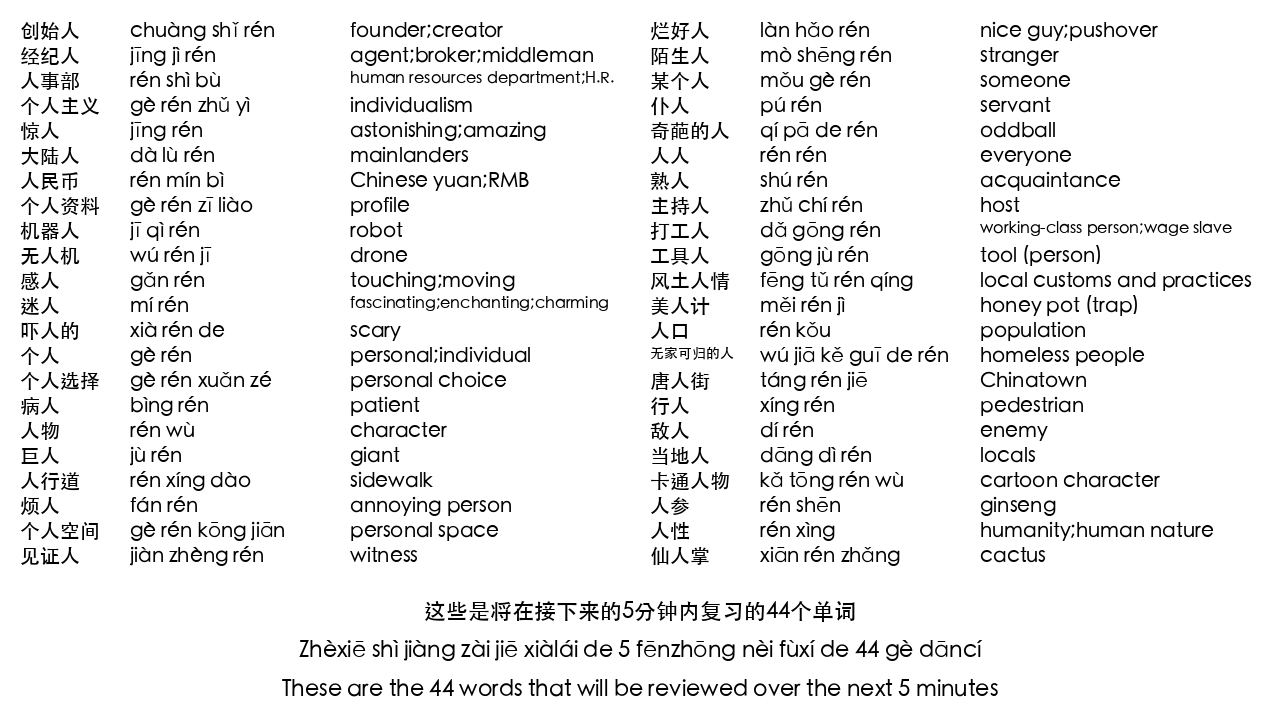

In [14]:
subtitle_text = f'{nonvocab_slides['word_list']['chinese']}\n{nonvocab_slides['word_list']['pinyin']}\n{nonvocab_slides['word_list']['english']}'
subtitle_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in subtitle_text.split('\n')])
draw_on_wordlist = ImageDraw.Draw(img_only_list_of_words)
draw_on_wordlist.text(
    xy=(BG_SIZE[0]/2 - subtitle_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
    text=subtitle_text,
    font=NONVOCAB_AUDIO_TEXT_FONT,
    fill=NONVOCAB_AUDIO_TEXT_FILL,
    spacing=NONVOCAB_AUDIO_TEXT_SPACING,
    align=NONVOCAB_AUDIO_TEXT_ALIGN,
    )

img_file_path = f"{nonvocab_audio_path}{rrow['recording_name']}/word_list.png"
img_only_list_of_words.save(img_file_path)
my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

# 7. Create video
## 7a. Combine clips

In [15]:
# Display static clips as desired
clips_all = clips[rrow['recording_name']].copy()
for cs_name, cs_set in nonvocab_slides.items():
    image_with_duration = ImageClip(f'{nonvocab_audio_path}{rrow['recording_name']}/{cs_name}.png', duration=cs_set['duration']).with_start(cs_set['start'])
    if cs_set['clip_index'] >= 0:
        clips_all.insert(cs_set['clip_index'], image_with_duration)
    else:
        clips_all.append(image_with_duration)
print(len(clips_all))
clips_all[:5]

91


## 7b. Create whole video

In [ ]:
# Compare durations of audio and video
audio = AudioFileClip(f"{nonvocab_audio_path}{rrow['recording_name']}/audio.mp3")
all_clips_duration = sum(clip.duration for clip in clips_all)
audio_video_duration_diff = audio.duration - all_clips_duration
print(f"{rrow['recording_name']}: audio: {audio.duration:.3f}s, video: {all_clips_duration:.3f}s; difference: {audio_video_duration_diff:.3f}s")
if audio_video_duration_diff > 0.3:
    raise ValueError('Difference between audio and video durations too high.')

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    create_full_video_file(clips_all, rrow, nonvocab_audio_path)

0916_016_efirst_word_only_p1_4_one_character_vocab_person: audio: 298.490s, video: 298.445s; difference: 0.045s
MoviePy - Building video audio_files/files_by_video/0916_016_efirst_word_only_p1_4_one_character_vocab_person_video.mp4.
MoviePy - Writing audio in 0916_016_efirst_word_only_p1_4_one_character_vocab_person_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/files_by_video/0916_016_efirst_word_only_p1_4_one_character_vocab_person_video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/files_by_video/0916_016_efirst_word_only_p1_4_one_character_vocab_person_video.mp4
